# MLP (Multilayer perceptron) による画像の分類

Based on https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99

## Library の読み込み

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


ファイル関連定数

In [3]:
train_file = "./data/train.csv"
test_file = "./data/test.csv"
output_file = "mlp_keras.csv"

## データの読み込みと前処理

NumPyを使ってCSVファイルを読み込みます。（Pandasでもできますが、今回はNumpyの行列でデータを扱うので Numpy に統一しました）

In [4]:
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',') # 先頭行は読み込まない

In [5]:
raw_data # numpy array を表示

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [7, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [9, 0, 0, ..., 0, 0, 0]])

In [6]:
raw_data.shape # pd,shape と同様に、np.shale もある

(42000, 785)

In [7]:
raw_data[np.isnan(raw_data)] # 欠損値がないことを確認 ※ 欠損値の処理は pabndas の方が簡単

array([], dtype=int32)

scikit-learn の train_test_split() 関数を使って、訓練用のデータと検証用のデータに分ける

In [8]:
x_train, x_val, y_train, y_val = train_test_split(raw_data[:,1:], raw_data[:,0], test_size=0.1)

In [9]:
print("x_train:", x_train.shape)
print("x_val:", x_val.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)

x_train: (37800, 784)
x_val: (4200, 784)
y_train: (37800,)
y_val: (4200,)


最初の４０個のデータを白黒画像で表示

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


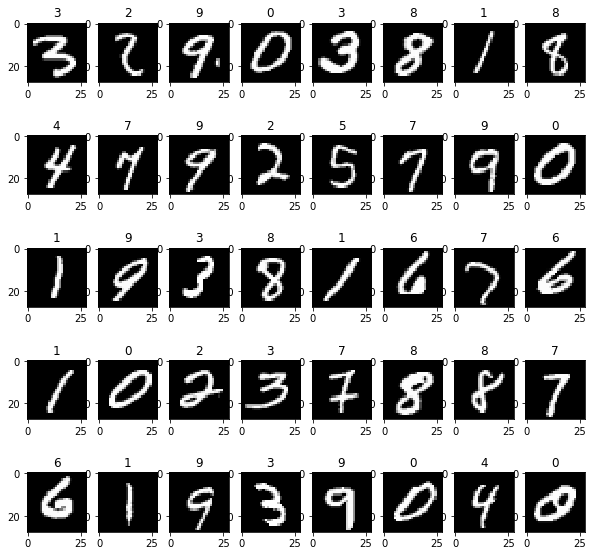

In [10]:
labels = ["0","1","2","3","4","5","6","7","8","9"]

plt.figure(figsize=(10, 10))
for i in range(0, 40):
    im = x_train[i].reshape(28,28)
    plt.subplot(5, 8, i + 1)
    plt.title(labels[y_train[i]])
    plt.tick_params(labelbottom="off",bottom="off") # x軸をオフ
    plt.tick_params(labelleft="off",left="off") # y軸をオフ
    plt.imshow(im, cmap='gray')

plt.show()

It would be possible to train the net on the original data, with pixel values 0 to 255. If we use the standard initialization methods for weights, however, data between 0 and 1 should make the net converge faster. 

In [11]:
# 値域の変換 [0-255] -> [0.0-1.0]
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.

In [12]:
x_train[100]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

The labels were given as integers between 0 and 9. We need to convert these to one-hot encoding, i.e. a 10x1 array with one 1 and nine 0:s, with the position of the 1 showing us the value. See the example, with the position of the 1 showing the correct value for the digit in the graph above.

In [13]:
# ラベルデータをOne-Hot形式に変換
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


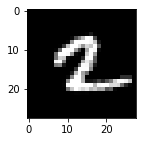

In [14]:
# example:
print(y_train[100])
fig, ax = plt.subplots(1, 1, figsize=(2,2))
plt.imshow(x_train[100].reshape(28,28), cmap='gray')

## モデルの作成と学習

Keras offers two different ways of defining a network. We will use the Sequential API, where you just add on one layer at a time, starting from the input.

In [15]:
# モデルを定義
model = Sequential()
model.add(Dense(512, input_shape=(784,))) # Dim(batch_size, input_dim) --> https://keras.io/ja/layers/core/#dense
model.add(Activation("relu"))
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(rate=0.25))   # ドロップアウト：過学習を防ぎモデルの精度を上げる方法の一つ
model.add(Dense(10))  # 出力層；目的変数の分類数
model.add(Activation("softmax")) 

In [16]:
# 学習の前に、モデル構造を確認
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total para

The model needs to be compiled before training can start. As our loss function, we use logloss which is called ''categorical_crossentropy" in Keras. Metrics is only used for evaluation. As optimizer, we could have used ordinary stochastic gradient descent (SGD), but Adam is faster.

In [17]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

We train once with a smaller learning rate to ensure convergence. We then speed things up, only to reduce the learning rate by 10% every epoch. Keras has a function for this: 

In [18]:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_val, y_val), 
                 batch_size=16, 
                 verbose=1,  # 0 = 表示なし，1 = プログレスバー，2 = 各試行毎に一行の出力．
                 epochs=50)

# モデルを保存
model.save_weights('mlp_keras.hdf5')

Train on 37800 samples, validate on 4200 samples
Epoch 1/50
37800/37800 [==============================] - 17s 461us/step - loss: 0.3884 - acc: 0.8920 - val_loss: 0.2023 - val_acc: 0.9414
Epoch 2/50
37800/37800 [==============================] - 15s 393us/step - loss: 0.1629 - acc: 0.9528 - val_loss: 0.1327 - val_acc: 0.9607
Epoch 3/50
37800/37800 [==============================] - 15s 397us/step - loss: 0.1100 - acc: 0.9679 - val_loss: 0.1122 - val_acc: 0.9688
Epoch 4/50
37800/37800 [==============================] - 15s 401us/step - loss: 0.0817 - acc: 0.9756 - val_loss: 0.0892 - val_acc: 0.9743
Epoch 5/50
37800/37800 [==============================] - 15s 410us/step - loss: 0.0598 - acc: 0.9822 - val_loss: 0.0845 - val_acc: 0.9755
Epoch 6/50
37800/37800 [==============================] - 15s 406us/step - loss: 0.0464 - acc: 0.9860 - val_loss: 0.0825 - val_acc: 0.9767
Epoch 7/50
37800/37800 [==============================] - 15s 401us/step - loss: 0.0346 - acc: 0.9896 - val_loss: 0.0

## 評価

In [19]:
# 学習済みのモデルを取得
# model.load_weights('mlp_keras.hdf5')

In [20]:
# 精度の評価
scores = model.evaluate(x_val, y_val, verbose=1)
print('Validation loss: {0:.4f}'.format(scores[0]))
print('Validation accuracy: {0:.4f}'.format(scores[1]))

4200/4200 [==============================] - 0s 58us/step
Validation loss: 0.1600
Validation accuracy: 0.9774


In [21]:
# 学習プロセスのプロット用関数

def Learning_Process_Plot(hist):
    acc = hist.history['acc'] # tf2.x: accuracy
    val_acc = hist.history['val_acc'] # tf2.x: val_accuracy
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label='Training acc', ls="-", marker="o")
    plt.plot(epochs, val_acc, label='Validation acc', ls="-", marker="x")
    plt.title('Training and validation accuracy')
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="best")

    plt.figure()

    plt.plot(epochs, loss, label='Training loss', ls="-", marker="o")
    plt.plot(epochs, val_loss, label='Validation loss', ls="-", marker="x")
    plt.title('Training and validation loss')
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(loc="best")

    plt.show()

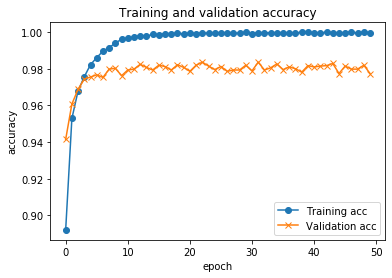

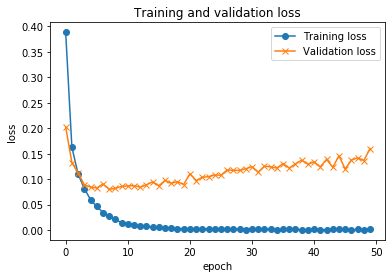

In [22]:
# 学習プロセスのプロット
Learning_Process_Plot(hist)

学習プロセスのプロットにより、過学習が起こり、Validation loss が増えていることが分かる

In [23]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[425   1   0   1   0   1   4   0   0   0]
 [  0 425   1   0   0   0   0   0   3   0]
 [  1   0 408   1   0   0   0   4   1   0]
 [  0   0   2 443   0   8   0   0   6   0]
 [  0   0   1   0 364   0   2   1   0   2]
 [  1   0   0   2   0 399   2   1   1   1]
 [  4   1   0   0   0   1 435   0   3   0]
 [  0   2   2   0   2   0   0 436   0   3]
 [  0   3   1   1   1   1   0   0 378   0]
 [  3   0   0   0  13   1   0   1   4 392]]


In [24]:
from sklearn.metrics import classification_report

labels = ["0","1","2","3","4","5","6","7","8","9"]

# Generate a classification report
report = classification_report(y_pred, y_true, target_names=labels)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       434
           1       0.99      0.98      0.99       432
           2       0.98      0.98      0.98       415
           3       0.97      0.99      0.98       448
           4       0.98      0.96      0.97       380
           5       0.98      0.97      0.98       411
           6       0.98      0.98      0.98       443
           7       0.98      0.98      0.98       443
           8       0.98      0.95      0.97       396
           9       0.95      0.98      0.97       398

    accuracy                           0.98      4200
   macro avg       0.98      0.98      0.98      4200
weighted avg       0.98      0.98      0.98      4200



## Submit

テストデータの読み込み

In [25]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")

学習したモデルを用いて予測

In [26]:
y_pred = model.predict(x_test, batch_size=64)
y_pred

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [28]:
y_pred = np.argmax(y_pred,axis=1) # One-hot データを分類データに変換
y_pred

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

提出用CSVファイルの作成

In [29]:
with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))